In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [3]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os


In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [5]:
sys.path.append('../')

In [6]:
import phononet as pn

In [7]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 166.50it/s]


In [8]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [9]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

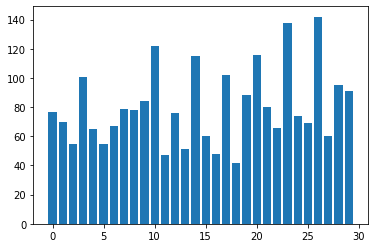

In [10]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

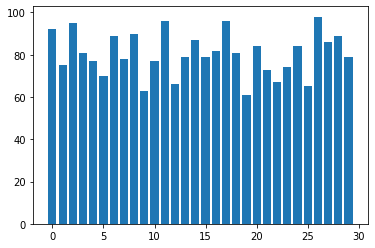

In [12]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [13]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        #print('balanced')
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        #print('not balanced')
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            #print('aug')
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            #print('not aug')
            yield X[idx],y[idx]




In [14]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [15]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes,print_f1=True,print_precision=False,print_recall=False, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        self.print_f1=print_f1
        self.print_precision=print_precision
        self.print_recall=print_recall
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            if self.print_precision:
                output['precision_{}'.format(i)]=results[0][i]
            if self.print_recall:
                output['recall_{}'.format(i)]=results[1][i]
            if self.print_f1:
                output['F1_{}'.format(i)]=results[2][i]

In [16]:
class MySequential(keras.Sequential):
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)
        return output
        
        
    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        y_pred = self(x, training=False)  # Forward pass
        # Compute the loss value.
        # The loss function is configured in `compile()`.
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        return output

In [17]:
from tensorflow.keras.models import Sequential

In [18]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [19]:
from tensorflow.keras.layers import Conv2D

In [20]:
ConvLayer=Conv2D

In [118]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,num_filters,filter_size,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.c=tf.keras.layers.Conv1D(num_filters,
                               filter_size,
                               data_format='channels_last',*args,**kwargs)
    
    def build(self,input_shape):
        self.num_channels=input_shape[1]
        
    def call(self,x):
        
        x=self.tr1(x)
        x=tf.stack([self.c(x[:,:,i]) for i in range(self.num_channels)],2)
        x=self.tr2(x)
        return x

In [211]:
120/1500*15

1.2

In [232]:
initial_time_only_conv_encoder=Sequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    OnlyTimeConvolution(100,100,strides=5,name='only_time_convolution',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    Conv2D(1,(1,1),padding='same'),
    #
    OnlyTimeConvolution(100,50,strides=5,name='only_time_convolution2',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    Conv2D(1,(1,1),padding='same'),
    #
],name='initial_time_only_conv_encoder')
initial_time_only_conv_encoder.summary()

Model: "initial_time_only_conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
only_time_convolution (OnlyT (None, 12, 281, 100)      10100     
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 12, 281, 100)      0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 12, 281, 100)      400       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 12, 140, 100)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 

In [233]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    initial_time_only_conv,
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu1'),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu2'),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu3'),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding='same',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu4'),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
initial_time_only_conv (Sequ (None, 12, 12, 1)         6206      
_________________________________________________________________
zero_padding2d_128 (ZeroPadd (None, 12, 14, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 12, 64)        640       
_________________________________________________________________
relu1 (LeakyReLU)            (None, 10, 12, 64)        0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 10, 12, 64)        256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 6, 64)         0         
_________________________________________________________________
drop1 (Dropout)              (None, 10, 6, 64)    

In [234]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [235]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
75/75 [==============================] - 17s 227ms/step - loss: 3.5588 - accuracy: 0.0421 - F1_0: 0.0273 - F1_1: 0.0114 - F1_2: 0.0179 - F1_3: 0.0256 - F1_4: 0.0033 - F1_5: 0.0855 - F1_6: 0.0988 - F1_7: 0.0417 - F1_8: 0.0295 - F1_9: 0.0889 - F1_10: 0.0300 - F1_11: 0.0071 - F1_12: 0.0019 - F1_13: 0.0173 - F1_14: 0.0585 - F1_15: 0.0726 - F1_16: 0.0736 - F1_17: 0.0152 - F1_18: 0.0752 - F1_19: 0.0427 - F1_20: 0.0181 - F1_21: 0.0105 - F1_22: 0.0113 - F1_23: 0.0021 - F1_24: 0.0126 - F1_25: 0.0402 - F1_26: 0.0783 - F1_27: 0.0069 - F1_28: 0.0131 - F1_29: 0.0863 - val_loss: 3.4894 - val_accuracy: 0.0275 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0301 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0152 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.1538 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0444 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0448 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0000e+00 - val_F1

Epoch 8/100
75/75 [==============================] - 19s 253ms/step - loss: 2.2488 - accuracy: 0.3283 - F1_0: 0.3369 - F1_1: 0.2292 - F1_2: 0.1218 - F1_3: 0.1988 - F1_4: 0.5466 - F1_5: 0.3663 - F1_6: 0.3465 - F1_7: 0.2925 - F1_8: 0.4071 - F1_9: 0.3216 - F1_10: 0.4368 - F1_11: 0.2224 - F1_12: 0.2033 - F1_13: 0.1591 - F1_14: 0.4192 - F1_15: 0.5281 - F1_16: 0.2414 - F1_17: 0.2974 - F1_18: 0.4345 - F1_19: 0.0681 - F1_20: 0.4031 - F1_21: 0.2168 - F1_22: 0.3489 - F1_23: 0.1674 - F1_24: 0.2963 - F1_25: 0.1611 - F1_26: 0.4451 - F1_27: 0.2902 - F1_28: 0.4183 - F1_29: 0.2876 - val_loss: 2.3194 - val_accuracy: 0.3140 - val_F1_0: 0.0000e+00 - val_F1_1: 0.1000 - val_F1_2: 0.3590 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4848 - val_F1_5: 0.1750 - val_F1_6: 0.3600 - val_F1_7: 0.4500 - val_F1_8: 0.3175 - val_F1_9: 0.3111 - val_F1_10: 0.2381 - val_F1_11: 0.0571 - val_F1_12: 0.1034 - val_F1_13: 0.1053 - val_F1_14: 0.0000e+00 - val_F1_15: 0.5897 - val_F1_16: 0.2597 - val_F1_17: 0.1176 - val_F1_18: 0.2476 - va

Epoch 15/100
75/75 [==============================] - 18s 241ms/step - loss: 1.7026 - accuracy: 0.4817 - F1_0: 0.4472 - F1_1: 0.4127 - F1_2: 0.4331 - F1_3: 0.3398 - F1_4: 0.7526 - F1_5: 0.5221 - F1_6: 0.4386 - F1_7: 0.4424 - F1_8: 0.5168 - F1_9: 0.4800 - F1_10: 0.6559 - F1_11: 0.3923 - F1_12: 0.2804 - F1_13: 0.5623 - F1_14: 0.5245 - F1_15: 0.6461 - F1_16: 0.3130 - F1_17: 0.3993 - F1_18: 0.6006 - F1_19: 0.4126 - F1_20: 0.3901 - F1_21: 0.2771 - F1_22: 0.5888 - F1_23: 0.3546 - F1_24: 0.5256 - F1_25: 0.3495 - F1_26: 0.4896 - F1_27: 0.3758 - F1_28: 0.5130 - F1_29: 0.4371 - val_loss: 2.0213 - val_accuracy: 0.3884 - val_F1_0: 0.3846 - val_F1_1: 0.5000 - val_F1_2: 0.4390 - val_F1_3: 0.0488 - val_F1_4: 0.6250 - val_F1_5: 0.1455 - val_F1_6: 0.4889 - val_F1_7: 0.5000 - val_F1_8: 0.2400 - val_F1_9: 0.4444 - val_F1_10: 0.4500 - val_F1_11: 0.0784 - val_F1_12: 0.2041 - val_F1_13: 0.4167 - val_F1_14: 0.0800 - val_F1_15: 0.6250 - val_F1_16: 0.4898 - val_F1_17: 0.4750 - val_F1_18: 0.2581 - val_F1_19: 0.

Epoch 22/100
75/75 [==============================] - 17s 221ms/step - loss: 1.3785 - accuracy: 0.5675 - F1_0: 0.5175 - F1_1: 0.5431 - F1_2: 0.4742 - F1_3: 0.4964 - F1_4: 0.7727 - F1_5: 0.6661 - F1_6: 0.6027 - F1_7: 0.6139 - F1_8: 0.5996 - F1_9: 0.5784 - F1_10: 0.7378 - F1_11: 0.4636 - F1_12: 0.2909 - F1_13: 0.6815 - F1_14: 0.5746 - F1_15: 0.7133 - F1_16: 0.3522 - F1_17: 0.5595 - F1_18: 0.5812 - F1_19: 0.5296 - F1_20: 0.6222 - F1_21: 0.4938 - F1_22: 0.6306 - F1_23: 0.4552 - F1_24: 0.4475 - F1_25: 0.3150 - F1_26: 0.7451 - F1_27: 0.5025 - F1_28: 0.7447 - F1_29: 0.4248 - val_loss: 2.0154 - val_accuracy: 0.3967 - val_F1_0: 0.1250 - val_F1_1: 0.5517 - val_F1_2: 0.4615 - val_F1_3: 0.0000e+00 - val_F1_4: 0.6667 - val_F1_5: 0.2069 - val_F1_6: 0.5106 - val_F1_7: 0.4000 - val_F1_8: 0.3448 - val_F1_9: 0.3611 - val_F1_10: 0.4091 - val_F1_11: 0.0784 - val_F1_12: 0.3492 - val_F1_13: 0.4615 - val_F1_14: 0.1250 - val_F1_15: 0.5938 - val_F1_16: 0.4783 - val_F1_17: 0.2000 - val_F1_18: 0.3175 - val_F1_19

Epoch 29/100
75/75 [==============================] - 17s 225ms/step - loss: 1.1396 - accuracy: 0.6313 - F1_0: 0.5562 - F1_1: 0.6151 - F1_2: 0.5647 - F1_3: 0.5277 - F1_4: 0.9213 - F1_5: 0.6598 - F1_6: 0.7375 - F1_7: 0.6462 - F1_8: 0.6380 - F1_9: 0.5587 - F1_10: 0.6295 - F1_11: 0.4834 - F1_12: 0.3253 - F1_13: 0.6172 - F1_14: 0.7117 - F1_15: 0.7519 - F1_16: 0.6596 - F1_17: 0.5308 - F1_18: 0.7577 - F1_19: 0.6715 - F1_20: 0.7355 - F1_21: 0.6344 - F1_22: 0.5962 - F1_23: 0.6424 - F1_24: 0.6904 - F1_25: 0.4790 - F1_26: 0.5898 - F1_27: 0.4259 - F1_28: 0.7615 - F1_29: 0.4979 - val_loss: 2.0209 - val_accuracy: 0.4256 - val_F1_0: 0.7200 - val_F1_1: 0.6207 - val_F1_2: 0.5263 - val_F1_3: 0.0930 - val_F1_4: 0.6667 - val_F1_5: 0.3721 - val_F1_6: 0.4783 - val_F1_7: 0.5641 - val_F1_8: 0.2222 - val_F1_9: 0.5385 - val_F1_10: 0.5128 - val_F1_11: 0.2162 - val_F1_12: 0.2667 - val_F1_13: 0.4516 - val_F1_14: 0.1053 - val_F1_15: 0.5185 - val_F1_16: 0.4000 - val_F1_17: 0.4789 - val_F1_18: 0.3778 - val_F1_19: 0.

Epoch 36/100
75/75 [==============================] - 19s 254ms/step - loss: 1.0044 - accuracy: 0.6829 - F1_0: 0.7545 - F1_1: 0.6870 - F1_2: 0.6100 - F1_3: 0.5664 - F1_4: 0.8695 - F1_5: 0.6641 - F1_6: 0.7004 - F1_7: 0.7472 - F1_8: 0.7035 - F1_9: 0.4970 - F1_10: 0.7093 - F1_11: 0.5613 - F1_12: 0.5835 - F1_13: 0.7813 - F1_14: 0.6050 - F1_15: 0.7976 - F1_16: 0.6563 - F1_17: 0.7496 - F1_18: 0.7524 - F1_19: 0.6802 - F1_20: 0.8422 - F1_21: 0.6788 - F1_22: 0.8234 - F1_23: 0.3789 - F1_24: 0.7220 - F1_25: 0.3332 - F1_26: 0.6227 - F1_27: 0.5332 - F1_28: 0.6846 - F1_29: 0.6077 - val_loss: 1.9826 - val_accuracy: 0.4311 - val_F1_0: 0.5455 - val_F1_1: 0.4286 - val_F1_2: 0.4444 - val_F1_3: 0.0455 - val_F1_4: 0.7273 - val_F1_5: 0.1569 - val_F1_6: 0.4333 - val_F1_7: 0.4118 - val_F1_8: 0.2000 - val_F1_9: 0.5769 - val_F1_10: 0.4211 - val_F1_11: 0.2642 - val_F1_12: 0.3934 - val_F1_13: 0.3448 - val_F1_14: 0.1667 - val_F1_15: 0.5385 - val_F1_16: 0.3333 - val_F1_17: 0.3390 - val_F1_18: 0.4638 - val_F1_19: 0.

Epoch 43/100
75/75 [==============================] - 17s 228ms/step - loss: 0.9301 - accuracy: 0.7075 - F1_0: 0.8225 - F1_1: 0.6701 - F1_2: 0.6043 - F1_3: 0.6298 - F1_4: 0.8917 - F1_5: 0.7514 - F1_6: 0.7072 - F1_7: 0.6844 - F1_8: 0.7895 - F1_9: 0.6963 - F1_10: 0.7920 - F1_11: 0.5142 - F1_12: 0.4780 - F1_13: 0.6749 - F1_14: 0.4239 - F1_15: 0.8157 - F1_16: 0.6105 - F1_17: 0.7119 - F1_18: 0.8670 - F1_19: 0.7373 - F1_20: 0.6615 - F1_21: 0.6971 - F1_22: 0.7617 - F1_23: 0.4598 - F1_24: 0.7105 - F1_25: 0.7573 - F1_26: 0.7790 - F1_27: 0.6872 - F1_28: 0.7051 - F1_29: 0.6393 - val_loss: 2.0180 - val_accuracy: 0.4325 - val_F1_0: 0.5455 - val_F1_1: 0.6250 - val_F1_2: 0.4262 - val_F1_3: 0.1224 - val_F1_4: 0.5556 - val_F1_5: 0.3273 - val_F1_6: 0.5000 - val_F1_7: 0.4643 - val_F1_8: 0.1905 - val_F1_9: 0.4906 - val_F1_10: 0.4444 - val_F1_11: 0.2813 - val_F1_12: 0.2642 - val_F1_13: 0.3333 - val_F1_14: 0.1250 - val_F1_15: 0.5106 - val_F1_16: 0.3810 - val_F1_17: 0.3607 - val_F1_18: 0.4000 - val_F1_19: 0.

Epoch 50/100
75/75 [==============================] - 17s 222ms/step - loss: 0.7953 - accuracy: 0.7433 - F1_0: 0.6487 - F1_1: 0.6952 - F1_2: 0.6559 - F1_3: 0.6251 - F1_4: 0.9502 - F1_5: 0.6694 - F1_6: 0.6989 - F1_7: 0.7935 - F1_8: 0.8089 - F1_9: 0.6788 - F1_10: 0.6959 - F1_11: 0.6402 - F1_12: 0.6337 - F1_13: 0.6465 - F1_14: 0.7232 - F1_15: 0.8150 - F1_16: 0.8146 - F1_17: 0.7888 - F1_18: 0.8842 - F1_19: 0.8074 - F1_20: 0.7899 - F1_21: 0.7036 - F1_22: 0.8660 - F1_23: 0.6033 - F1_24: 0.7086 - F1_25: 0.6944 - F1_26: 0.8254 - F1_27: 0.6681 - F1_28: 0.8708 - F1_29: 0.6485 - val_loss: 1.9888 - val_accuracy: 0.4545 - val_F1_0: 0.5000 - val_F1_1: 0.6341 - val_F1_2: 0.4286 - val_F1_3: 0.1639 - val_F1_4: 0.6957 - val_F1_5: 0.1379 - val_F1_6: 0.5946 - val_F1_7: 0.6341 - val_F1_8: 0.2857 - val_F1_9: 0.4286 - val_F1_10: 0.6222 - val_F1_11: 0.3846 - val_F1_12: 0.5312 - val_F1_13: 0.1905 - val_F1_14: 0.0952 - val_F1_15: 0.4800 - val_F1_16: 0.4000 - val_F1_17: 0.4308 - val_F1_18: 0.4324 - val_F1_19: 0.

Epoch 57/100
75/75 [==============================] - 18s 242ms/step - loss: 0.7615 - accuracy: 0.7592 - F1_0: 0.7710 - F1_1: 0.7590 - F1_2: 0.7431 - F1_3: 0.5858 - F1_4: 0.9490 - F1_5: 0.7978 - F1_6: 0.8811 - F1_7: 0.8144 - F1_8: 0.8437 - F1_9: 0.5565 - F1_10: 0.7695 - F1_11: 0.6813 - F1_12: 0.6291 - F1_13: 0.7477 - F1_14: 0.7616 - F1_15: 0.8202 - F1_16: 0.7051 - F1_17: 0.7968 - F1_18: 0.9303 - F1_19: 0.7466 - F1_20: 0.7533 - F1_21: 0.6516 - F1_22: 0.7713 - F1_23: 0.6633 - F1_24: 0.7377 - F1_25: 0.6949 - F1_26: 0.6842 - F1_27: 0.6175 - F1_28: 0.7895 - F1_29: 0.7590 - val_loss: 2.0868 - val_accuracy: 0.4477 - val_F1_0: 0.5263 - val_F1_1: 0.7222 - val_F1_2: 0.4706 - val_F1_3: 0.0426 - val_F1_4: 0.7000 - val_F1_5: 0.2000 - val_F1_6: 0.4444 - val_F1_7: 0.5333 - val_F1_8: 0.3333 - val_F1_9: 0.4068 - val_F1_10: 0.5263 - val_F1_11: 0.1081 - val_F1_12: 0.3729 - val_F1_13: 0.2609 - val_F1_14: 0.0870 - val_F1_15: 0.5926 - val_F1_16: 0.5238 - val_F1_17: 0.4308 - val_F1_18: 0.3939 - val_F1_19: 0.

Epoch 64/100
75/75 [==============================] - 17s 223ms/step - loss: 0.6497 - accuracy: 0.7983 - F1_0: 0.8890 - F1_1: 0.8555 - F1_2: 0.6505 - F1_3: 0.6797 - F1_4: 0.9587 - F1_5: 0.8045 - F1_6: 0.8707 - F1_7: 0.8070 - F1_8: 0.7712 - F1_9: 0.7760 - F1_10: 0.7687 - F1_11: 0.7291 - F1_12: 0.6476 - F1_13: 0.8713 - F1_14: 0.7646 - F1_15: 0.8526 - F1_16: 0.8389 - F1_17: 0.7707 - F1_18: 0.8217 - F1_19: 0.7767 - F1_20: 0.6073 - F1_21: 0.7556 - F1_22: 0.9178 - F1_23: 0.5714 - F1_24: 0.7539 - F1_25: 0.7227 - F1_26: 0.8320 - F1_27: 0.6736 - F1_28: 0.7108 - F1_29: 0.7964 - val_loss: 2.1447 - val_accuracy: 0.4339 - val_F1_0: 0.4348 - val_F1_1: 0.3721 - val_F1_2: 0.4167 - val_F1_3: 0.0000e+00 - val_F1_4: 0.6818 - val_F1_5: 0.1739 - val_F1_6: 0.4390 - val_F1_7: 0.5263 - val_F1_8: 0.4333 - val_F1_9: 0.4000 - val_F1_10: 0.5106 - val_F1_11: 0.3030 - val_F1_12: 0.4444 - val_F1_13: 0.5000 - val_F1_14: 0.0714 - val_F1_15: 0.6667 - val_F1_16: 0.5000 - val_F1_17: 0.3810 - val_F1_18: 0.4000 - val_F1_19

In [236]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [237]:
#model.save_weights('phase_1_weights_100_epochs')

In [238]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [239]:
training_history_file

'training_history/tmp3.json'

In [240]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [241]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [242]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

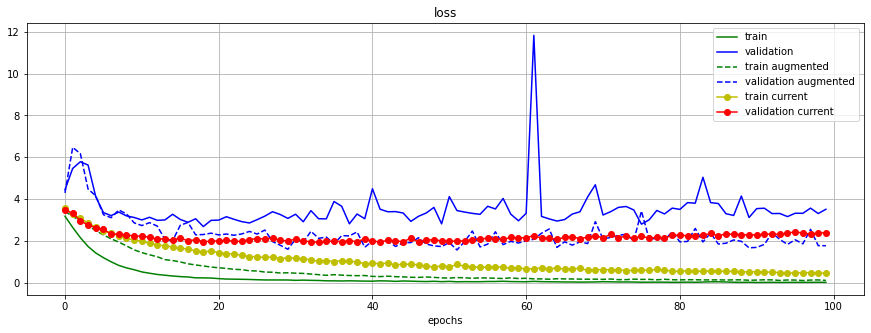

In [243]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

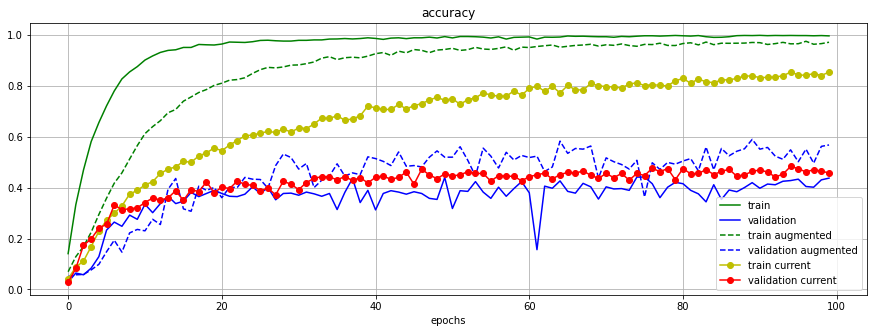

In [244]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

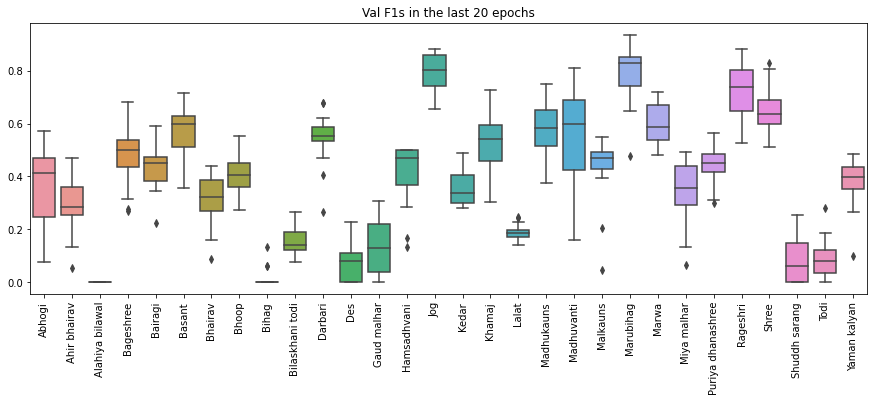

In [245]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

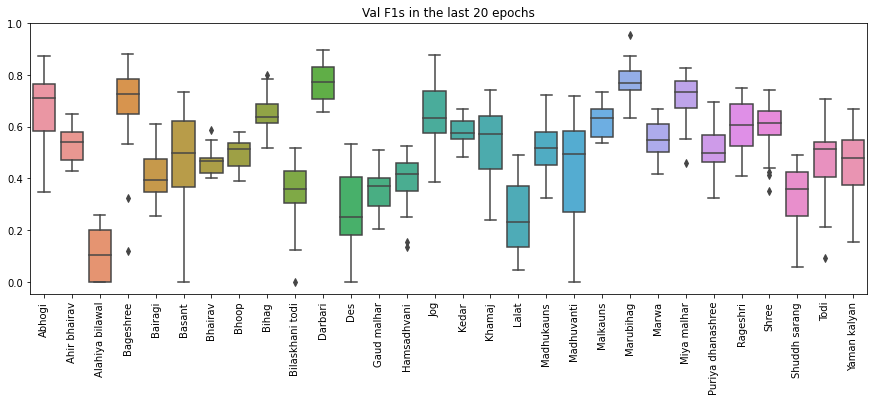

In [246]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

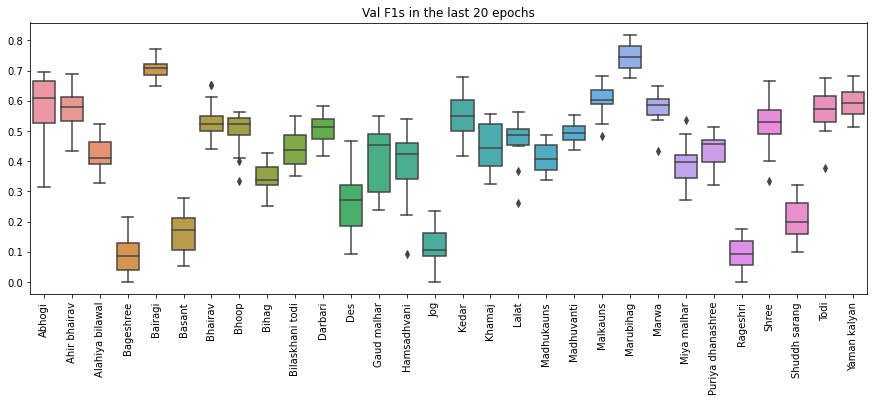

In [247]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

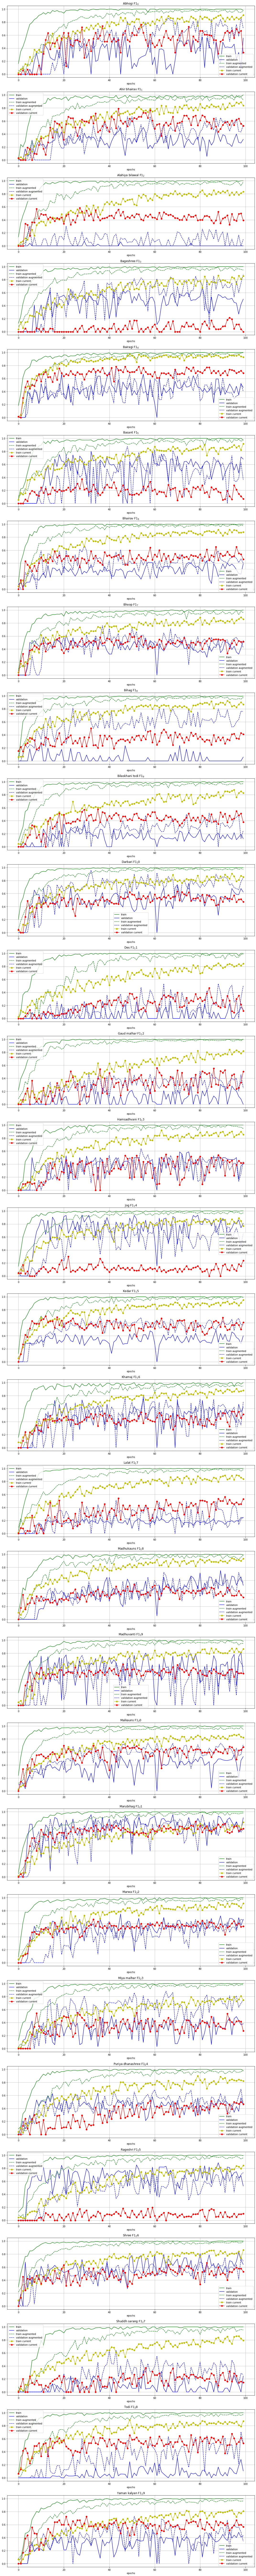

In [248]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [249]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [250]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


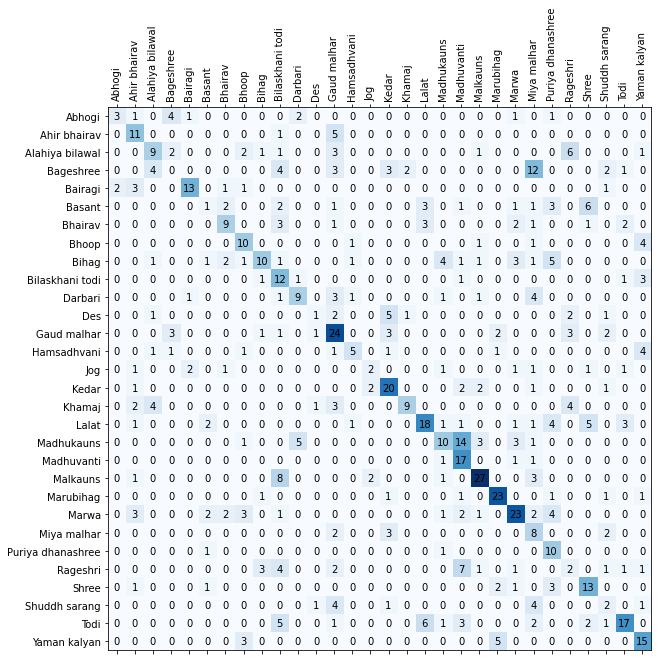

In [251]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [252]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [253]:
precision,recall,f1=process_confusion_matrix(cm)

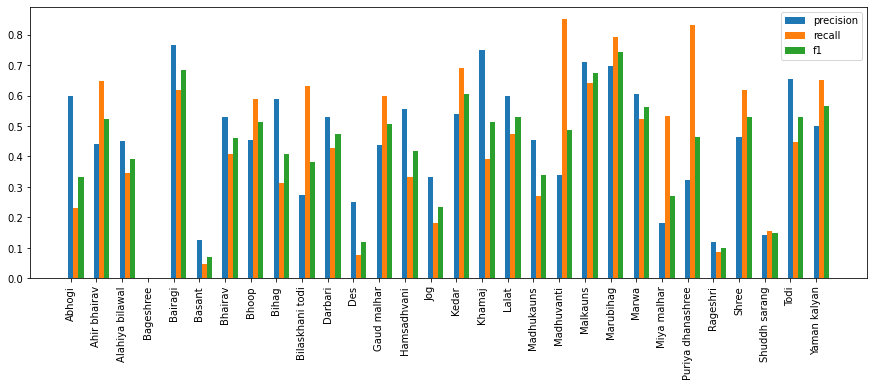

In [254]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>